# Análisis de los 25 retailers más grandes de Estados Unidos

In [1]:
# Importar librerías aquí
import pandas as pd
import numpy as np

In [2]:
# Importar datos aquí
df = pd.read_csv('largest_us_retailers.csv')

In [3]:
df.head(25)

,Company,Sales,Stores,Sales/Avg. Store,Store Count Growth,Category
0,Walmart US,658119,4574.0,65.649725,0.012843,Supercenters
1,Kroger,115037,3931.0,30.031850,0.053887,Grocery
2,Costco,90048,495.0,187.795620,0.066810,Warehouse Club
3,Home Depot,83976,1965.0,42.735878,0.000000,Home Improvement
4,Walgreen Boots,78924,8002.0,9.810927,-0.010511,Drug Stores
5,CVS incl. Target,77792,9813.0,8.825959,0.255662,Drug Stores
6,Amazon,71687,NaN,NaN,NaN,Electronic/Mail Order
7,Target,71208,1772.0,39.982033,-0.010056,Supercenters
8,Lowe's,60311,1828.0,33.311792,0.019520,Home Improvement
9,Albertsons,56829,2326.0,23.877731,-0.044371,Grocery


## Support functions

### Constants

In [4]:
FLOATS = {"float16": 4, "float32": 8, "float64": 1024}
INTS = {
    "int8": (-128, 127),
    "int16": (-32768, 32767),
    "int32": (-2147483648, 2147483647),
    "int64": (-9223372036854775808, 9223372036854775807)
}
UINTS = {
    "uint8": (0, 255),
    "uint16": (0, 65535),
    "uint32":  (0, 4294967295),
    "uint64":  (0, 18446744073709551615)
}

### Functions

In [5]:
def get_types_recommendations(df):
    recommendation = {}
    des_stats = df.describe(include='all')
    null_stats = df.isna().sum().to_frame().T
    null_stats.rename(index={0: "nulls"}, inplace=True)
    des_stats = pd.concat([des_stats, null_stats])

    for index, value in df.dtypes.iteritems():
        data = des_stats[index]
        
        if str(value) == "float64":
            recommend_type = _types_float(data)
        elif str(value) == "int64":
            unique_values = df[index].value_counts()
            recommend_type = _types_int(data, unique_values)
        elif str(value) == "object":
            recommend_type = _types_object(data, value)
        else:
            recommend_type = str(value)

        recommendation[index] = {
            "original": str(value),
            "recommendation": recommend_type
        }
    
    return recommendation

def _types_float(data):
    min_val = data['min']
    max_val = data['max']
    len_min = len(str(min_val).split('.')[1])
    len_max = len(str(max_val).split('.')[1])

    for k, v in FLOATS.items():
        limit_min = len_min in range(v)
        limit_max = len_max in range(v)

        if limit_min is True and limit_max is True:
            recommend_type = k
            break
            
    return recommend_type
            
            
def _types_int(data, unique_values):
    min_val = data['min']
    max_val = data['max']

    size = data['count'] / 3
    int_rec = [
        k for k, v in INTS.items()
        if min_val >= v[0] and max_val <= v[1]
    ]
    uint_rec = [
        k for k, v in UINTS.items()
        if min_val >= v[0] and max_val <= v[1]
    ]

    if unique_values.shape[0] <= size:
        recommend_type = 'category'
    elif uint_rec:
        recommend_type = uint_rec[0]
    elif int_rec:
        recommend_type = int_rec[0]
    else:
        recommend_type = str(value)
        
    return recommend_type
                    
                    
def _types_object(data, value):
    counts = data['count']
    unique = data['unique']

    # In this moment I am check this value (it is experimental)
    count_uniq = int(counts / 3)

    if unique == 2:
        recommend_type = 'bool'
    elif unique <= count_uniq:
        recommend_type = 'category'
    else:
        recommend_type = str(value)
        
    return recommend_type


recommendations = get_types_recommendations(df)
df_types = pd.DataFrame(recommendations)
df_types = df_types.T
df_types

,original,recommendation
Company,object,object
Sales,int64,uint32
Stores,float64,float16
Sales/Avg. Store,float64,float64
Store Count Growth,float64,float64
Category,object,object


#### Applying new datatypes

In [6]:
df.memory_usage()

Index                 128
Company               200
Sales                 200
Stores                200
Sales/Avg. Store      200
Store Count Growth    200
Category              200
dtype: int64

In [7]:
df_types = df_types[['recommendation']]

for index, row in df_types.iterrows():
    df[index] = df[index].astype(row['recommendation'])
    
df.memory_usage()

Index                 128
Company               200
Sales                 100
Stores                 50
Sales/Avg. Store      200
Store Count Growth    200
Category              200
dtype: int64

## I. Preguntas del negocio

In [8]:
df

,Company,Sales,Stores,Sales/Avg. Store,Store Count Growth,Category
0,Walmart US,658119,4576.0,65.649725,0.012843,Supercenters
1,Kroger,115037,3932.0,30.031850,0.053887,Grocery
2,Costco,90048,495.0,187.795620,0.066810,Warehouse Club
3,Home Depot,83976,1965.0,42.735878,0.000000,Home Improvement
4,Walgreen Boots,78924,8000.0,9.810927,-0.010511,Drug Stores
5,CVS incl. Target,77792,9816.0,8.825959,0.255662,Drug Stores
6,Amazon,71687,NaN,NaN,NaN,Electronic/Mail Order
7,Target,71208,1772.0,39.982033,-0.010056,Supercenters
8,Lowe's,60311,1828.0,33.311792,0.019520,Home Improvement
9,Albertsons,56829,2326.0,23.877731,-0.044371,Grocery


### 1. ¿Cuál es el promedio de ventas sin contar a la compañía dominante?

In [9]:
df_mean_without_max = df[df['Company'] != df[['Company', 'Sales']].max()['Company']]
mean_of_sales = df_mean_without_max['Sales'].mean()
mean_of_sales

46602.416666666664

### 2. ¿Cuánto dinero en ventas generó la mayoría de las compañías?

In [10]:
sales_without_max = df_mean_without_max['Sales'].mean()
sales_with_max = df['Sales'].sum()

sales_without_max, sales_with_max

(46602.416666666664, 1776577)

### 3. ¿Cuántas tiendas tiene la mayoría de las compañías?

In [11]:
stores_without_max = sum(df_mean_without_max['Stores'].dropna().tolist())
stores_with_max = sum(df['Stores'].dropna().tolist())

stores_without_max, stores_with_max

(75158.0, 79734.0)

### 4. ¿La cantidad de tiendas está relacionada con la cantidad de ventas? Es decir, ¿si una empresa tiene más tiendas tendrá más dinero de ventas?

<AxesSubplot:>

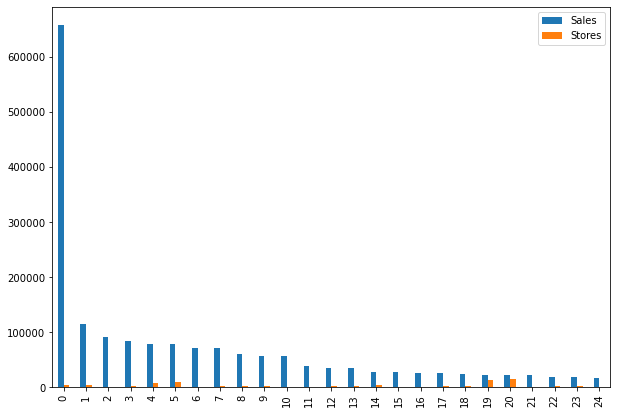

In [12]:
df_plot = df[['Sales', 'Stores']]
# df_plot = df_plot.cumsum()
df_plot.plot(kind="bar", figsize=(10,7))

In [13]:
df[['Sales', 'Stores']].corr()

,Sales,Stores
Sales,1.000000,0.063408
Stores,0.063408,1.000000


### 5. ¿Cuál es el rango que existe entre las ventas?

<AxesSubplot:>

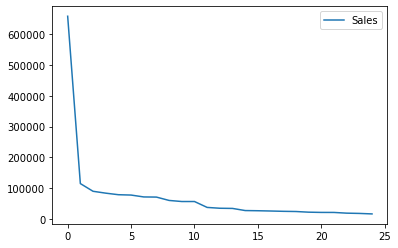

In [14]:
df[['Sales']].plot()

In [15]:
range_min, range_max = df['Sales'].min(), df['Sales'].max()
range_min, range_max

(16592, 658119)

### 6. ¿Cuáles son las 5 empresas que más tiendas físicas tienen? ¿Cuáles de ellas están dentro de las 5 empresas que más ventas tuvieron?

In [22]:
sales_top_5 = df[['Company', 'Sales']].sort_values('Sales', ascending=False).head(5)
stores_top_5 = df[['Company', 'Stores']].sort_values('Stores', ascending=False).head(5)

top_joins = pd.merge(sales_top_5, stores_top_5, on='Company')
top_joins

,Company,Sales,Stores
0,Walmart US,658119,4576.0
1,Walgreen Boots,78924,8000.0


## II. Preguntas opcionales

### 7. ¿Qué categoría de compañía generó más ventas?

,Sales
Category,
Supercenters,745919
Grocery,297164
Drug Stores,184202
Home Improvement,144287
Warehouse Club,90048


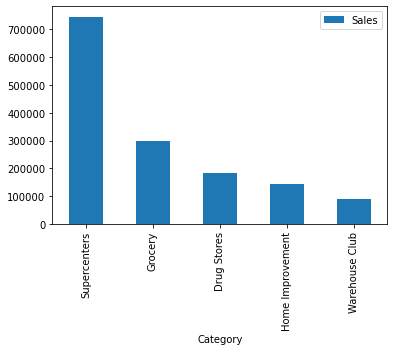

In [43]:
category_group = df[['Sales', 'Category']].groupby('Category')['Sales'].sum()
category_group = category_group.to_frame().sort_values('Sales', ascending=False)
category_group[:5].plot(kind="bar")
category_group[:5]

### 8. ¿Cuál es la compañía que en relación con su cantidad de tiendas físicas genera más ventas?

### 9. ¿Cuáles compañías venden de forma exclusivamente online? ¿Sus ventas destacan sobre las que también tienen tiendas físicas?

## III. Tus propias preguntas

### 10. Pregunta

### 11. Pregunta

### 12. Pregunta

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2bfa4cbb-f12f-425e-97f0-1def9e3caab4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>